# Register of renewable energy power plants in Germany

This is a Jupyter Notebook that downloads and cleans up the data from the project [EnergyMap.info](http://www.energymap.info/) and  the German Federal Network Agency for Electricity, Gas, Telecommunications, Posts and Railway [BNetzA](http://www.bundesnetzagentur.de/). EnergyMap.info provides a register of all renewable energy power plants in Germany.

Since 2014 the BNetzA is responsible to publish the register of renewable power plants due to the [EEG 2014 (German)](http://www.gesetze-im-internet.de/eeg_2014/) [(English)](http://www.res-legal.eu/search-by-country/germany/single/s/res-e/t/promotion/aid/feed-in-tariff-eeg-feed-in-tariff/lastp/135/). Note: From June 2014 on all power plants are published in two seperated MS Excel-files for roof mounted PV systems and all other renewable power plants.

The register includes all RE power plants which are eligible for the German feed-in tariff (according to the EEG law). EnergyMap.info collects all data which is mandatorily reported from the four German TSO's to the BNetzA and merges it. Additionally EnergyMap.info validates and converts the data to a standard format.



# License

* This notebook is published under the GNU GPL v3 license. http://www.gnu.org/licenses/gpl-3.0.en.html.
* This notebook is developed by Wolf-Dieter Bunke [(E-Mail)](mailto:wolf-dieter.bunke@uni-flensburg.de)

# Table of contents 

* [Register of renewable energy power plants in Germany](#Register-of-renewable-energy-power-plants-in-Germany)
* [License](#Licence)
* [1. Import python modules](#1.-Import-python-modules)
     * [1.1 First Data overview of EnergyMap.info](#1.1-First-Data-overview-of-EnergyMap.info)
* ...
* [7 Documenting the data package in a JSON object](#7-Documenting-the-data-package-in-a-JSON-object)
* [8 Write Data Package to disk](#8-Write-Data-Package-to-disk)


# 1. Import Python modules

In [1]:
%matplotlib inline


from collections import OrderedDict
import io
import json
import os
import subprocess
import zipfile


import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import requests
import yaml  # http://pyyaml.org/, pip install pyyaml, conda install pyyaml


## 1.1 Data overview from EnergyMap.info

* Data discription from source: http://www.energymap.info/download/
* Download from: http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip
    * Last Dataset: 08.2015
    * Number of entries: 1.565.438 
    * File sides: 363,9 MB

##### Please note: Since the last change in the EEG law in 2014, three out of four German transmission network operators (TSO) stopped reporting

* **Report status by TSO:**
    * TenneT TSO GmbH:           still reporting, last reported entries 2015-08-17
    * 50Hertz Transmission GmbH: last report 2014-11-26
    * Amprion GmbH:              last report 2014-10-09
    * TransnetBW GmbH:           last report 2014-11-24

* **###### Concequence:** ???

## 1.2 Data overview from other data sources

German Federal Network Agency for Electricity, Gas, Telecommunications, Posts and Railway (BNetzA) renewable Power plant register ("Anlagenregister"): [PV](http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/Datenmeldungen/Meldungen_Aug-Juni2015.xls?__blob=publicationFile&v=1) and [other renewables](http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/VOeFF_Anlagenregister/2015-07_Veroeff_AnlReg.xls?__blob=publicationFile&v=1) renewable energy power plants, provided by the BNetzA.

* EUROSTAT
* [Netztransparenz](https://www.netztransparenz.de/de/Anlagenstammdaten.htm), Download: [zip-File](https://www.netztransparenz.de/de/file/UeNB-EEG-Anlagenstammdaten_2013.zip)
* German TSO's
    * 50Hertz
    * Amprion
    * TenneT
    * TransnetBW

# 2. Extracting data from EnergyMap.info

In the beginning we using EnergyMap.info for all historical data.

## 2.1 Download, unzip and load EnergyMap.info-CSV as data frame

We are creating a [pandas DataFrame](http://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe) in order to handle our data.

--> Time for loading data: approx. 5-10 min.

In [2]:
url_energymap = 'http://www.energymap.info/download/eeg_anlagenregister_2015.08.utf8.csv.zip'
r = requests.get(url_energymap)
z = zipfile.ZipFile(io.BytesIO(r.content))

In [3]:
# Creating data frame from energyMap.info data
# time: approx. 5-10 min
# eeg_data = pd.read_csv(z.open('eeg_anlagenregister_2015.08.utf8.csv'),
eeg_data = pd.read_csv('../eeg_anlagenregister_2015.08.utf8.csv',
                       sep=';',  # CSV field separator, default is ','
                       thousands='.',  # Thousands separator, default is ','
                       decimal=',',  # Decimal separator, default is '.'
                       header=None,
                       names=None,
                       parse_dates=[0], 
                       dayfirst=True, 
                       comment='#',
                       low_memory=False)

## 2.2 Definition of column names

Here we translate the original column names from EnergyMap.info from German to English. The new English column names are assigned to our data frame.

Original Name|Translation|column name
-|-|-
Inbetriebnahmedatum|start-up date|start_up_date
GeoDBID| Geometry id | gid 
PLZ | post code or ZIP|postcode
Ort| name od city, vilage, municipality|	city
Strasse| street name and hous number|street_address
Anlagenschluessel| power plant indificator number|power_plant_id
Anlagentyp| Type of generation|	type_of_generation
Anlagenuntertyp| Sub type of generation|subtype
Nennleistung(kWp_el)| rated power |	rated_power
Einspeisespannungsebene| Type of grid connection, voltage level|voltage_level
DSO-EIC| Energy Identification Code (EIC) for distribution system operator (DSO) accounting area  |dso_eic
DSO| Name of distribution system operator|dso
TSO-EIC| Energy Identification Code (EIC) for transmission system operator (TSO)| tso_eic
TSO	| Name of TSO|tso
kWh(2013)| Annual power production of the year 2013| kwh2013
kWh(average)|Average power production|	kwh_avg
kWh/kW| Own calculation of EnergyMap of full-load hours |kwh_per_kw
EEG-Verguetungsschluessel|German EEG renumeration code	|eeg_renumeration_code
Gemeindeschluessel|	Municipality code of Germany | municipality_id
GPS-Lat| GPS Latetude coordinats| gps_lon
GPS-Lon| GPS Longetude coordinats|gps_lat
GPS-Genauigkeit(dm)| GPS accuracy of coordinats| gps_accuracy
Validierung| Data validation| validation

In [4]:
# set new column names 
eeg_data.columns = ['start_up_date', 'gid', 'postcode', 'city', 'street_address',
                    'power_plant_id', 'type_of_generation', 'subtype',
                    'rated_power', 'voltage_level', 'dso_eic', 'dso', 'tso_eic',
                    'tso', 'kwh2013', 'kwh_avg', 'kwh_per_kw',
                    'eeg_renumeration_code', 'municipality_id',
                    'gps_lon','gps_lat','gps_accuracy','validation']

## 2.3  First look at the data frame (structure and format)

Here we look at the created data frame and the data formats of the different columns.

`DataFrame.info()` shows us the number of non-null (non-NA) values in each column, which can serve as a first indicator that something went wrong in a column

In [5]:
eeg_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1565438 entries, 0 to 1565437
Data columns (total 23 columns):
start_up_date            1565438 non-null datetime64[ns]
gid                      1555470 non-null float64
postcode                 1565438 non-null object
city                     1565438 non-null object
street_address           1275589 non-null object
power_plant_id           1560376 non-null object
type_of_generation       1560358 non-null object
subtype                  1157532 non-null object
rated_power              1560358 non-null float64
voltage_level            1560358 non-null object
dso_eic                  451473 non-null object
dso                      1560352 non-null object
tso_eic                  0 non-null float64
tso                      1559527 non-null object
kwh2013                  1463429 non-null float64
kwh_avg                  1419770 non-null float64
kwh_per_kw               1560129 non-null float64
eeg_renumeration_code    1510180 non-null objec

In [6]:
eeg_data.head()

,start_up_date,gid,postcode,city,street_address,power_plant_id,type_of_generation,subtype,rated_power,voltage_level,...,tso,kwh2013,kwh_avg,kwh_per_kw,eeg_renumeration_code,municipality_id,gps_lon,gps_lat,gps_accuracy,validation
0,1994-03-25,13790,79280,Au,NaN,E10775011000000000000015114900001,Solarstrom,Freifläche,3,07 (NS),...,TransnetBW GmbH,NaN,1676.833,558,SoK81a------01,8315003,47.95,7.833,30000,OK
1,1994-06-30,13790,79280,Au,NaN,E10775011000000000000000001500001,Solarstrom,Freifläche,3,07 (NS),...,TransnetBW GmbH,1362,1515.714,505,SoK81a------01,8315003,47.95,7.833,30000,OK
2,1994-09-19,13790,79280,Au,NaN,E10775011000000000000015116700001,Solarstrom,Freifläche,3,07 (NS),...,TransnetBW GmbH,852,1064.571,354,SoK81a------01,8315003,47.95,7.833,30000,"?(kWh/kW),"
3,1996-05-07,13790,79280,Au,NaN,E10775011000000000000015116600001,Solarstrom,Freifläche,3,07 (NS),...,TransnetBW GmbH,1894,4746.143,1582,SoK81a------01,8315003,47.95,7.833,30000,"?(kWh/kW),"
4,2001-04-23,13790,79280,Au,NaN,E10775011000000000000000029500001,Solarstrom,Freifläche,2,07 (NS),...,TransnetBW GmbH,1648,1819.000,909,SoK81a------01,8315003,47.95,7.833,30000,OK


In [7]:
eeg_data.tail()

,start_up_date,gid,postcode,city,street_address,power_plant_id,type_of_generation,subtype,rated_power,voltage_level,...,tso,kwh2013,kwh_avg,kwh_per_kw,eeg_renumeration_code,municipality_id,gps_lon,gps_lat,gps_accuracy,validation
1565433,2015-07-31,NaN,99999,keine Angabe,Noch nicht in Stammdaten,E2056801-AGGREGATION-FIKTIV-BIOMA,Biomasse,NaN,9978.400,05 (MS),...,TenneT TSO GmbH,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"?(PLZ),"
1565434,2015-07-31,NaN,99999,keine Angabe,Noch nicht in Stammdaten,E2056801-AGGREGATION-FIKTIV-SOLAR,Solarstrom,NaN,7598.642,07 (NS),...,TenneT TSO GmbH,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"?(PLZ),"
1565435,2015-07-31,NaN,99999,keine Angabe,Noch nicht in Stammdaten,E2056801-AGGREGATION-FIKTIV-WASSE,Wasserkraft,NaN,886.500,07 (NS),...,TenneT TSO GmbH,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"?(PLZ),"
1565436,2015-07-31,NaN,99999,keine Angabe,Noch nicht in Stammdaten,E2056801-AGGREGATION-FIKTIV-WIND-,Windkraft,NaN,12142.760,05 (MS),...,TenneT TSO GmbH,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"?(PLZ),?(SpE 7 vs. 13047 kW),"
1565437,2015-07-31,NaN,99999,keine Angabe,Noch nicht in Stammdaten erfasst,E2301301-AGGREGATION-FIKTIV-Solar,Solarstrom,NaN,349.005,07 (NS),...,TenneT TSO GmbH,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,"?(PLZ),?(SpE 7 vs. 282 kW),"


### Delete data entries which are not part of the register

Postcodes have to be a numerical value, so we remove any strings and check for invalid numerical postcodes.

In [8]:
# Parse postcode column as a numeric datatype,
# setting any values that can't be parsed to NaN

eeg_data['postcode_parsed'] = eeg_data.postcode.convert_objects(convert_numeric=True)

In [9]:
# Check what how many unparseable postcodes we had in the original data

idx_postcode_unparseable = eeg_data[eeg_data.postcode_parsed.isnull()].index

eeg_data.loc[idx_postcode_unparseable, :].postcode.value_counts()

keine    30
O04WF    21
dtype: int64

In [10]:
# Check how many postcodes are set to 99999

idx_postcode_invalid = eeg_data.query('postcode_parsed == 99999').index

len(idx_postcode_invalid)

11

In [11]:
# Drop rows with unparseable or invalid postcodes

idx_to_drop = idx_postcode_unparseable.append(idx_postcode_invalid)

eeg_data = eeg_data.drop(idx_to_drop)

In [12]:
# sum in Gigawatt 
eeg_data['rated_power'].sum() / 1000000

88.210031807999968

### Another look at the data

In [13]:
eeg_data.query('validation == "OK"').sum()['rated_power'] / 1000000

73.677274531002027

In [14]:
# sum in Gigawatt with validation OK
eeg_data[eeg_data['validation'] == 'OK'].sum()['rated_power'] / 1000000

73.677274531002027

In [15]:
eeg_data['rated_power'].describe()

count    1560296.000000
mean          56.534165
std          519.103471
min            0.000000
25%            5.540000
50%            9.240000
75%           19.500000
max       288000.000000
Name: rated_power, dtype: float64

In [16]:
# group by type in MW
eeg_data.groupby(['type_of_generation'])['rated_power'].sum() / 1000

type_of_generation
Biomasse        7033.302073
Erdwärme          33.643000
Gas              630.166040
Solarstrom     37108.875856
Wasserkraft     1643.631559
Windkraft      41760.413280
Name: rated_power, dtype: float64

In [17]:
eeg_data.groupby(['start_up_date'])['rated_power'].sum() / 1000

start_up_date
1895-11-16      0.070000
1898-07-01      0.400000
1899-11-01      0.264000
1899-12-30      0.796000
1899-12-31      0.490000
1900-01-01      2.656000
1900-10-01      1.200000
1901-01-01      0.013000
1901-07-01      0.044000
1901-11-01      0.080000
1901-12-31      0.880000
1903-01-01      0.008000
1904-01-01      0.121000
1905-01-01      1.560000
1905-03-14      0.055000
1905-04-11      0.700000
1905-04-15      1.200000
1905-04-16      0.800000
1905-04-19      0.040000
1905-04-22      0.400000
1905-05-08      0.560000
1905-05-09      0.400000
1905-06-25      0.056000
1905-06-26      0.090000
1905-06-27      1.053000
1906-01-01      0.662000
1906-09-01      0.080000
1907-01-01      1.652200
1907-06-01      0.060000
1907-12-31      0.767000
                 ...    
2015-07-31      0.105480
2015-08-01    138.250000
2015-08-04      6.155040
2015-08-05      9.231210
2015-08-06      0.004800
2015-08-07      0.010140
2015-08-08      0.012680
2015-08-10      0.029835
2015-08-11 

### 2.3.3 Strange date

* ToDo:
     * e.g. 2046-09-27, 1895-11-16 
     * ...


##  2.4 Translation of type and subtype

### 2.4.1 types

type_of_generation| OPSD naming
-|-
Gas | gas
Erdwärme| geothermal
Wasserkraft| hydro
Windkraft|wind 
Biomasse|biomass 
Solarstrom| solar

In [18]:
# Replace names
eeg_data['type_of_generation'] = eeg_data.type_of_generation.str \
                                         .replace('Gas', 'gas') \
                                         .replace('Erdwärme', 'geothermal') \
                                         .replace('Wasserkraft', 'hydro') \
                                         .replace('Windkraft', 'wind') \
                                         .replace('Biomasse', 'biomass') \
                                         .replace('Solarstrom', 'solar')

# Get an overview
eeg_data.groupby(['type_of_generation'])['rated_power'].agg(['sum', 'count'])

,sum,count
type_of_generation,,
biomass,7033302.073000,15206
gas,630166.040000,829
geothermal,33643.000000,29
hydro,1643631.559000,7459
solar,37108875.856003,1512290
wind,41760413.280000,24483


### 2.4.2 Subtypes

subtype| OPSD naming
-|-
Altholz|waste_wood 
Biogas|biogas 
Biogas (Gasnetzentnahme)|biogas_gas_grid 
Biogas (Trockenfermentation)|biogas_dry_fermentation
Biotreibstoffe|biofuel 
Deponiegas|landfill_gas 
Freifläche|ground_mounted 
Gebäude|roof_mounted 
Grubengas|mine_gas 
Holz| wood
Klärgas| sewage_gas
Offshore|offshore 
Onshore|onshore

In [19]:
# Replace names
eeg_data['subtype'] = eeg_data.subtype.str \
                              .replace('Onshore', 'onshore') \
                              .replace('Offshore', 'offshore') \
                              .replace('Klärgas', 'sewage_gas') \
                              .replace('Holz', 'wood') \
                              .replace('Grubengas', 'mine_gas') \
                              .replace('Gebäude', 'roof_mounted') \
                              .replace('Freifläche', 'ground_mounted') \
                              .replace('Deponiegas', 'landfill_gas') \
                              .replace('Biotreibstoffe', 'biofuel') \
                              .replace('Biogas (Trockenfermentation)', 'biogas_dry_fermentation') \
                              .replace('Altholz', 'waste_wood ') \
                              .replace('Biogas (Gasnetzentnahme)', 'biogas_gas_grid') \
                              .replace('Biogas', 'biogas')

# Get an overview
eeg_data.groupby(['subtype'])['rated_power'].agg(['sum', 'count'])

,sum,count
subtype,,
biofuel,117663.741000,362
biogas,3955174.832000,9577
biogas_dry_fermentation,38063.000000,64
biogas_gas_grid,255955.120000,867
ground_mounted,10367382.861000,115305
landfill_gas,128535.120000,239
mine_gas,291933.000000,101
offshore,2211950.000000,534
onshore,23408082.410000,13716


## 2.5  Overview of the first result

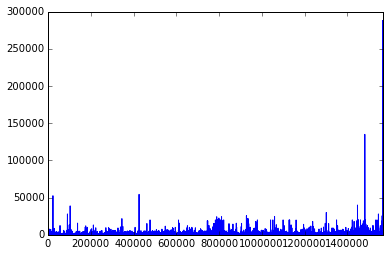

In [20]:
eeg_data['rated_power'].plot()

## 2.6 Take a look into the statistics of BNetzA

In [21]:
url_eeg2013 ='http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/ZahlenDatenInformationen/EEGinZahlen_2013.xls;?__blob=publicationFile&v=3'
eeg2013 = pd.ExcelFile(url_eeg2013)
eeg2013.sheet_names

['Inhaltsverzeichnis',
 '1. Allgemeine Erläuterungen',
 '2.1 Überblick Deutschland',
 '2.2 Überblick Bundesländer',
 '2.3 Letzverbraucherabsatz',
 '2.4 Historische Entwicklung',
 '3.1 Wind onshore',
 '3.2 Wind offshore',
 '3.3 PV insgesamt',
 '3.4 PV Kategorien',
 '3.5 Biomasse',
 '3.6 Wasser',
 '3.7 Sonstige Energieträger',
 '4.1 Regelzonen',
 '4.2 Anschlussebenen',
 '4.3 Größenklassen',
 '5. Vermiedene NE']

In [22]:
sta2013 = eeg2013.parse('2.1 Überblick Deutschland', skiprows=3, skip_footer=9)
sta2013

,Angaben insgesamt 2013,Erneuerbare Energieträger nach dem EEG,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Summe
0,NaN,Wasser,DKG-Gas*,Biomasse,Geothermie,Wind onshore,Wind offshore,Solar,NaN
1,Installierte Leistung ingesamt (in MW),1487.234,551.1497,6052.434,30.485,33456.73,508.3,36710.05,78796.39
2,Neuinbetriebnahmen (in MW),76.00509,0.658,167.1971,11.315,2900.455,240,2643.308,6038.938
3,Installierte Anlagen insgesamt (Anzahl),6972,686,13420,8,22746,113,1429860,1473805
4,Eingespeiste Jahresarbeit (GWh),6265.111,1775.743,36258.36,79.8633,50802.71,904.8184,28785.09,124871.7
5,Vergütungszahlungen (Mio.€),420.2323,48.16691,6158.377,18.65474,3523.229,122.6029,9346.043,19637.31
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Angaben nach Vergütungsarten 2013,Erneuerbare Energieträger nach dem EEG,NaN,NaN,NaN,NaN,NaN,NaN,Summe
8,NaN,Wasser,DKG-Gas*,Biomasse,Geothermie,Wind onshore,Wind offshore,Solar,NaN
9,Feste Einspeisevergütung nach § 16 EEG 2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### TODO: 
* sum by year and type
* calc error of missing rated power e.g.
* ...

# 3 Get new data from BNetzA

* Introduction ...


## 3.1 Download BNetzA register #1

Note: Here dataset without roof-mounted PV systems. (For dataset of roof-mounted PV systems see [3.2](#Download-PV-roof-mounted-master-data-register-from-BNetzA))

In [23]:
# set URL
url_bna1 ='http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/VOeFF_Anlagenregister/2015_08_Veroeff_AnlReg.xls?__blob=publicationFile&v=1'
xl = pd.ExcelFile(url_bna1)
xl.sheet_names

['Gesamtübersicht',
 'Flexprämie § 54 EEG',
 'Zubau Biomasse',
 'Zubau Wind an Land']

In [24]:
# create data frame
bnetza1 = xl.parse("Gesamtübersicht")

In [25]:
# overview of columns
list(bnetza1.columns)

['Meldedatum',
 'Meldegrund',
 'Anlagennummer',
 '1.8 EEG-Anlagenschlüssel',
 '3.1 Genehmigungs-datum',
 '3.2 Genehmigungs-behörde',
 '3.3 Genehmigungs-Aktenzeichen',
 '3.4 Geplantes Inbetriebnahme-datum',
 '3.5 Errichtungs-frist',
 '4.1 Energieträger',
 '4.2 Installierte Leistung [kW]',
 '4.2.1 Inst. Leistung vor Leistungs-änderung (ohne Flexprämie)',
 '4.2.2 Inst. Leistung nach Leistungs-änderung (ohne Flexprämie)',
 '4.3 Tatsächliche Inbetrieb-nahme',
 '4.4 Datum Leistungs-änderung',
 '4.5 Stilllegungs-datum',
 '4.6 Name der Anlage',
 '4.7 Strasse bzw. Flurstück',
 '4.8 Haus-nummer',
 '4.9 Postleit-zahl',
 '4.10 Ort bzw. Gemarkung',
 'Gemeinde-schlüssel',
 '4.11 Bundesland',
 'UTM-Zonenwert',
 'UTM-East',
 'UTM-North',
 '4.13 Zugehörigkeit Anlagenpark',
 '4.13.1  Name des Anlagenparks',
 '4.14 Spannungsebene',
 '4.15 Netzanschlusspunkt',
 'Zählpunktbezeichnung',
 '4.16 Name des Netzbetreibers',
 '4.17 Fernsteuerbarkeit durch:',
 '4.18 Gemeinsame techn. Einrichtung',
 '4.19 Inanspruc

In [26]:
# count number of columns
bnetza1.dtypes.count()

72

## 3.2 Download BNetzA register #2: roof-mounted PV

In [27]:
url_bnetza_pv = 'https://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/Sachgebiete/Energie/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/Datenmeldungen/Meldungen_Aug-Juni2015.xls?__blob=publicationFile&v=1'
pv = pd.ExcelFile(url_bnetza_pv)
pv.sheet_names

['August 2014',
 'September 2014',
 'Oktober 2014',
 'November 2014',
 'Dezember 2014',
 'Januar 2015',
 'Februar 2015',
 'März 2015',
 'April 2015',
 'Mai 2015',
 'Juni 2015']

In [28]:
# Combine all sheets into one DataFrame
pvdf = pd.concat(pv.parse(sheet, skiprows=10) for sheet in pv.sheet_names)

In [29]:
pvdf.count()

Anlage \nBundesland                  49904
Anlage \nOrt oder Gemarkung          49904
Anlage \nPLZ                         49904
Anlage \nStraße oder Flurstück *)     3345
Inbetriebnahmedatum **)              49904
Installierte \nNennleistung [kWp]    49904
Meldungsdatum                        49904
Unnamed: 7                               3
dtype: int64

In [30]:
# drop NULL "Unnamed:" column
pvdf = pvdf.drop(pvdf.columns[[7]], axis=1)

### 3.2.1 Rename columns of  PV roof mounted data

Original Name|Translation|column name
-|-|-
Anlage \nBundesland|federal state|federal_state
Anlage \nOrt oder Gemarkung |Place, city  | city
Anlage \nPLZ | post code or ZIP| postcode
Anlage \nStraße oder Flurstück *)| street name and hous number|	street_address
Inbetriebnahmedatum \**)| Start-up date|start_up_date
Installierte \nNennleistung [kWp] | installed rated power |	rated_power
Meldungsdatum | notification date | notification_date 



In [31]:
pvdf.columns = ['federal_state', 'city', 'postcode','street_address',
                'start_up_date', 'rated_power', 'notification_date']

In [32]:
# take a look into the structure and format
pvdf.dtypes

federal_state                object
city                         object
postcode                      int64
street_address               object
start_up_date        datetime64[ns]
rated_power                 float64
notification_date    datetime64[ns]
dtype: object

## 3.3 Merge data sources

until August 2014:
* EnergyMap: data on (all) renewable energy power plants

since August 2014:
* BNetzA #1: data on all renewable energa power plants (except roof-mounted PV)
* BNetzA #2: data on roof-mounted PV only

In [33]:
energymap_pv = eeg_data[eeg_data['subtype'] == 'roof_mounted']
energymap_pv.count()

start_up_date            1016431
gid                      1010731
postcode                 1016431
city                     1016431
street_address            844266
power_plant_id           1016431
type_of_generation       1016431
subtype                  1016431
rated_power              1016431
voltage_level            1016431
dso_eic                   298805
dso                      1016431
tso_eic                        0
tso                      1016431
kwh2013                   969031
kwh_avg                   920031
kwh_per_kw               1016307
eeg_renumeration_code    1008366
municipality_id          1010153
gps_lon                  1011196
gps_lat                  1011196
gps_accuracy             1011196
validation               1016431
postcode_parsed          1016431
dtype: int64

### 3.3.1 Marker for data source

In [34]:
#
frames = [energymap_pv, pvdf]
# key is an marker x = EnergyMap y = BNetzA
result_pv = pd.concat(frames, keys=['x', 'y'])

In [35]:
# Overview
result_pv.count()

city                     1066335
dso                      1016431
dso_eic                   298805
eeg_renumeration_code    1008366
federal_state              49904
gid                      1010731
gps_accuracy             1011196
gps_lat                  1011196
gps_lon                  1011196
kwh2013                   969031
kwh_avg                   920031
kwh_per_kw               1016307
municipality_id          1010153
notification_date          49904
postcode                 1066335
postcode_parsed          1016431
power_plant_id           1016431
rated_power              1066335
start_up_date            1066335
street_address            847611
subtype                  1016431
tso                      1016431
tso_eic                        0
type_of_generation       1016431
validation               1016431
voltage_level            1016431
dtype: int64

In [36]:
# Delete not needed columns
opsd_pv = result_pv.loc[:, ['start_up_date', 'rated_power', 'federal_state',
                            'city', 'postcode', 'street_address',
                            'gps_lat', 'gps_lon', 'gps_accuracy', 'validation']]
opsd_pv.reset_index(drop=True)

,start_up_date,rated_power,federal_state,city,postcode,street_address,gps_lat,gps_lon,gps_accuracy,validation
0,2009-03-17,4.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
1,2009-06-25,3.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
2,2009-07-31,8.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
3,2009-12-11,14.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
4,2009-12-22,46.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
5,2009-12-22,140.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
6,2009-12-28,12.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
7,2010-02-22,10.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
8,2010-03-19,3.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK
9,2010-04-23,30.000,NaN,Au,79280,NaN,7.833,47.950,30000,OK


In [37]:
# PV roof mounted systems in GW
opsd_pv.rated_power.sum() / 1000000

22.096739091999996

# 4 Geoplot testing



In [38]:
def draw_germany():
    """Returns a basemap centered on Germany"""
    plt.figure(figsize=(14, 10))
    return Basemap(projection='lcc', resolution='l',
                   llcrnrlon= 5.87, urcrnrlon=16.04,
                   llcrnrlat= 47, urcrnrlat= 55.1,
                   lat_1=47.26, lat_2=56, lon_0=6,
                   area_thresh=10000)


/Users/stefan/Anaconda/envs/sci/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


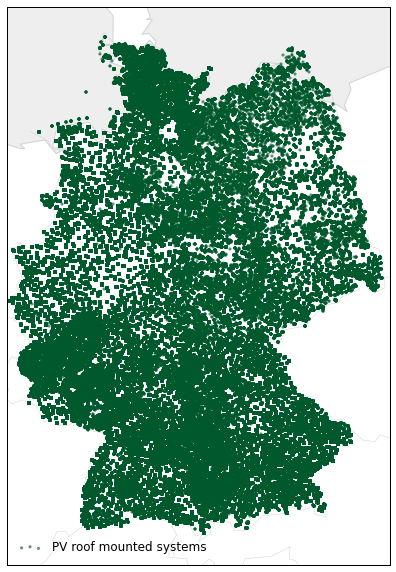

In [39]:
m = draw_germany()
# Draw map background
m.fillcontinents(color='white', lake_color='#eeeeee')
m.drawstates(color='lightgray')
m.drawcoastlines(color='lightgray')
m.drawcountries(color='lightgray')
m.drawmapboundary(fill_color='#eeeeee')

# get coordinates
lon = np.array(opsd_pv.gps_lon)
lat = np.array(opsd_pv.gps_lat)

# Plot PV systems entries
style = dict(s=5, marker='o', alpha=0.5, zorder=2)
m.scatter(lat, lon, latlon=True,
          label='PV roof mounted systems',
          color='#00592D', **style)

plt.legend(loc='lower left', frameon=False)

# 5 Georeferencing of missing GPS lon and lat


-- http://wiki.openstreetmap.org/wiki/Nominatim 

-- https://github.com/damianbraun/nominatim

-- https://pypi.python.org/pypi/geopy

In [40]:
# count missing geo data
opsd_pv.gps_lon.isnull().sum()

55139

## Evaluation of our data
 
For our evaluation of the data set we use different methods. 

1. count entries
2. sum the installed capacity by generation type
3. check date, Types, adresses, lon lat
4. ...


# 6 Validation column 

List of methods. Each Method error get one number e.g. 

Number | Method
-|-
1 | state_up_date < 1900
...| ...

# ...

# 7 Documenting the data package (meta data)

We document the data packages meta data in the specific format JSON as proposed by the Open Knowledge Foundation. See the Frictionless Data project by OKFN (http://data.okfn.org/) and the Data Package specifications (http://dataprotocols.org/data-packages/) for more details.

In order to keep the notebook more readable, we first formulate the metadata in the human-readable YAML format using a multi-line string. We then parse the string into a Python dictionary and save that to disk as a JSON file.

In [41]:
# Here we define meta data of the resulting data package.
# The meta data follows the specification at:
# http://dataprotocols.org/data-packages/

metadata = """

name: opsd-renewable-master-register-germany
title: Test data for master data register of roof mounted pv stystem in Germany.
description: This dataset is just for OPSD testing and contains the master data of Germany. For the beginning we are using the EnergyMap.info data set and BNetzA publications of pv master data.
version: 0.0.1
keywords: [master data register,power plants,solar,roof mounted PV stystem,renewables,germany]

resources:
    path: register_data_roof_mounted_pv_germany.csv
    format: csv
    mediatype: text/csv
    schema:  # Schema according to: http://dataprotocols.org/json-table-schema/        
        fields:
            - name: start_up_date
              description: Date of start up.
              type: datetime
              format: YYYY-MM-DDThh:mm:ssZ  # This MUST be in ISO 8601 format of YYYY-MM-DDThh:mm:ssZ in UTC time according to http://dataprotocols.org/json-table-schema/
            - name: rated_power
              description: Rated power of the roof mounted PV stystem in kW
              type: number
            - name: federal_state
              description: Name of federal state of PV system location
              type: number
            - name: city
              description: Name of city of PV system location
              type: text
            - name: postcode,
              description: Post code of PV system location
              type: number
            - name: street_address
              description: Name of street and house number of PV system location
              type: text
            - name: gps_lat
              description: GPS Latitude coordinates of PV system location
              type: number
            - name: gps_lon
              description: GPS Longitude coordinates of PV system location
              type: number
            - name: gps_accuracy
              description: GPS accuracy in meters
              type: number
            - name: validation
              description: Validation OK or comment for validation error. From EnergyMap.info
              type: text

licenses:
    - url: http://example.com/license/url/here
      name: License Name Here
      version: 1.0
      id: license-id-from-open

sources:
    - name: EnergyMap.info,
      web: http://www.energymap.info/download.html
    - name: Bundesnetzagentur - Veröffentlichung von im Anlagenregister registrierten Daten,
      web: http://www.bundesnetzagentur.de/cln_1422/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Anlagenregister/Anlagenregister_Veroeffentlichung/Anlagenregister_Veroeffentlichungen_node.html
    - name: Bundesnetzagentur - Datenmeldungen und EEG-Vergütungssätze für Photovoltaikanlagen,
      web: http://www.bundesnetzagentur.de/cln_1431/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/ErneuerbareEnergien/Photovoltaik/DatenMeldgn_EEG-VergSaetze/DatenMeldgn_EEG-VergSaetze_node.html    
    # Hier weitere Quellen

maintainers:
    - name: Wolf-Dieter Bunke,
      email: wolf-dieter.bunke@uni-flensburg.de,
      web: http://open-power-system-data.org/

views:
    # You can put hints here which kind of graphs or maps make sense to display your data. This makes the 
    # Data Package Viewer at http://data.okfn.org/tools/view automatically display visualazations of your data.
    # See http://data.okfn.org/doc/data-package#views for more details.    

# extend your datapackage.json with attributes that are not
# part of the data package spec
# you can add your own attributes to a datapackage.json, too

openpowersystemdata-enable-listing: True  # This is just an example we don't actually make use of yet.


"""

metadata = yaml.load(metadata)

datapackage_json = json.dumps(metadata, indent=4, separators=(',', ': '))

# 8 Write Data Package to disk

Again, we follow the Frictionless Data project's suggestions (see http://data.okfn.org/) to write a data package.

The data package consists of:
 * **datapackage.json** A file containing meta data of the data package
 * ***.csv** One or multiple CSV data files
 * **README.md** A readme (which is a copy of this Jupyter Notebook converted to Markdown format)

Following this file structure allows to use a number of tools (http://data.okfn.org/tools) designed specifically for data packages.

In [42]:
path_package = 'output/datapackage_testpackage'

os.makedirs(path_package, exist_ok=True)
    
opsd_pv.to_csv(os.path.join(path_package,
                            'register_data_roof_mounted_pv_germany.csv'))

with open(os.path.join(path_package, 'datapackage.json'), 'w') as f:
    f.write(datapackage_json)
    
##
# Make sure the filename here matches the filename of the notebook itself
##
nb_filename = 'Register_of_renewable_energy_power_plants_Germany_V001-Copy1.ipynb'

# Save a copy of the notebook to markdown, to serve as the package README file
subprocess.call(['jupyter', 'nbconvert', '--to', 'markdown', nb_filename])
path_readme = os.path.join(path_package, 'README.md')
try:
    os.remove(path_readme)
except Exception:
    pass
os.rename(nb_filename.replace('.ipynb', '.md'), path_readme)